In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')
sys.path.append('..')

In [229]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy
from src.speech_segmentation import SpeechSegmentation
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from typing import List

from scipy.stats import invgamma, chi, nakagami

### Binary Coordination (hard coupling)

We start with coordination as a binary variable. Vocalic series A and B are observed at different time scales. A single value of this series at a time step $t$ contains the average value of a specific vocalic feature whithin an utterance that ended at time $t$. If no utterance ended at that time, there's no link between the coordination variable and the vocalic series. That means the model structure is defined according to the data. The existance of coordination affects the coupling between series $A$ and $B$, that is, whether $B_t$ depends on $A_{t-1}$ and vice versa. 

We define by generating synthetic data for a model with the following parameters

$
\begin{align}
p(C_t) &= \text{Ber}(0) \\
p(C_t | C_t) &= \text{Geometric}(0.1) \\
p(A) &= p(B) = \mathcal{N}(0, 1) \\
p(A_{t(t)}|C_t, B_{t(t-1)}) &= p(A)^{1-C_t}\mathcal{N}(B_{t(t-1)}, 1)^{C_t} \\
p(B_{t(t)}|C_t, A_{t(t-1)}) &= p(B)^{1-C_t}\mathcal{N}(A_{t(t-1)}, 1)^{C_t}
\end{align}
$

This model makes a series of assumptions:

1. The process starts with no coordination 
2. Coordination is a discrete value (either it exists or not)
3. There's a 10% chance of change in the coordination from one time step to the next
4. Samples from one series are independent of each other, that means series A and B are sampled from their priors if there's no coordination.
5. Coordination if observed as a linear coupling betweeen the series.

First we will generate a series of coordination values over time and then we generate series A and B for two vocalic features: pitch and intensity.  

In [25]:
SEED = 0

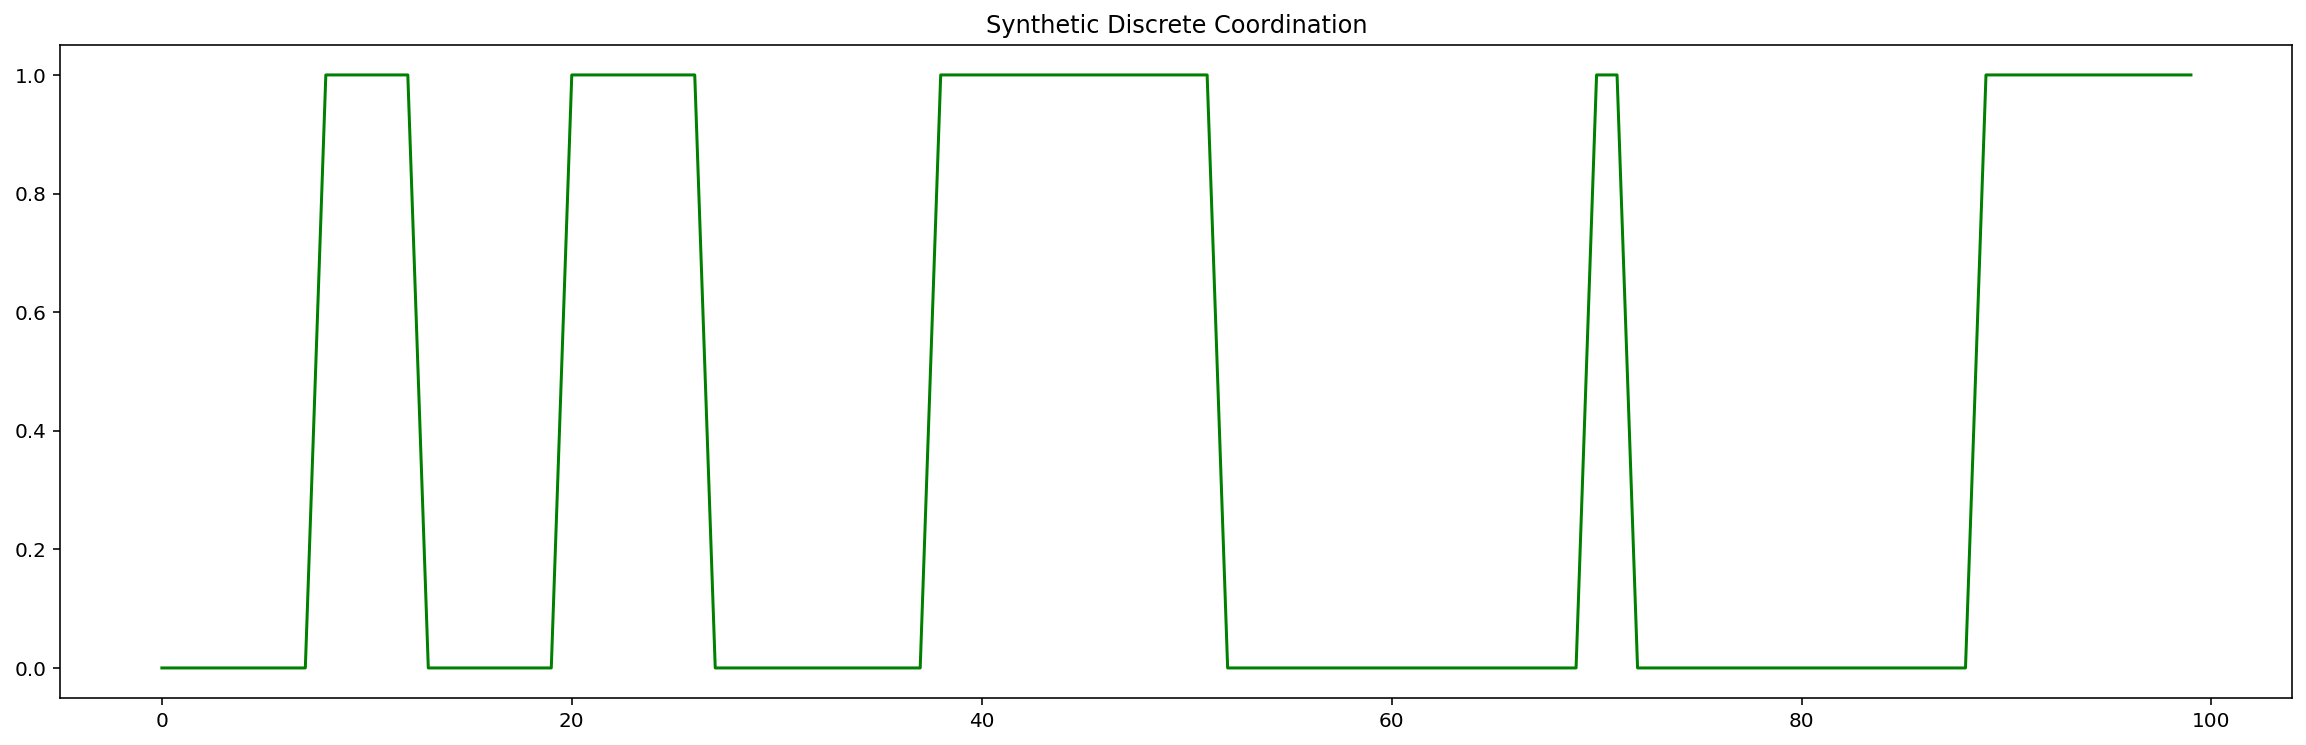

In [59]:
from scipy.stats import bernoulli, geom
from typing import List
import matplotlib.pyplot as plt
import random
import numpy as np

def generate_discrete_coordination(prior_p: float, transition_p: float, num_time_steps: int) -> List[int]:
    cs = []
    if num_time_steps > 0:
        cs.append(bernoulli.rvs(prior_p))
        for t in range(1, num_time_steps):
            # We can sample directly from a transition matrix instead of a geometric distribution.
            # It is the the same thing. That means that we change state if we sample 1 from a Bernoulli distribution.
            if bernoulli.rvs(transition_p) == 1: 
                # Flip the state
                cs.append(1 - cs[t-1])
            else:
                # Repeat the state
                cs.append(cs[t-1])
    return cs
                
def plot_coordination(cs: List[float]):
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(cs)), cs, color="green")
    plt.title("Synthetic Discrete Coordination")


random.seed(SEED)
np.random.seed(SEED)
num_time_steps = 100
discrete_cs = generate_discrete_coordination(0, 0.1, num_time_steps)
plot_coordination(discrete_cs)

Text(0.5, 1.0, 'Synthetic Pitch')

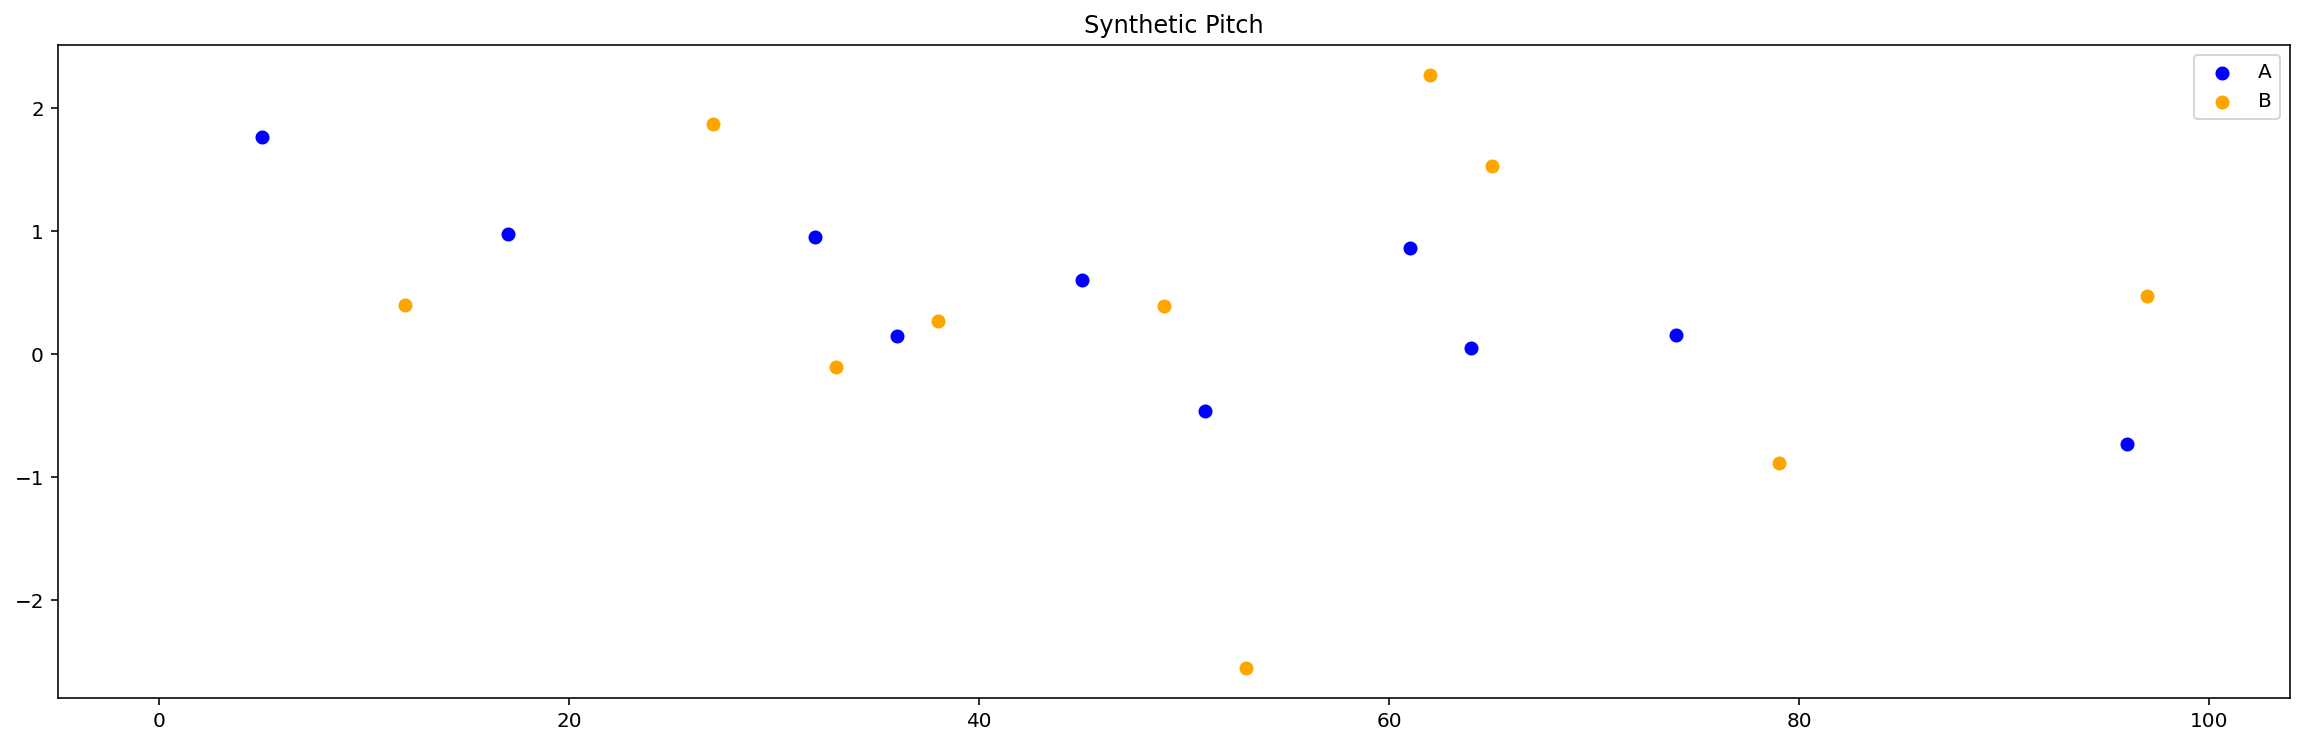

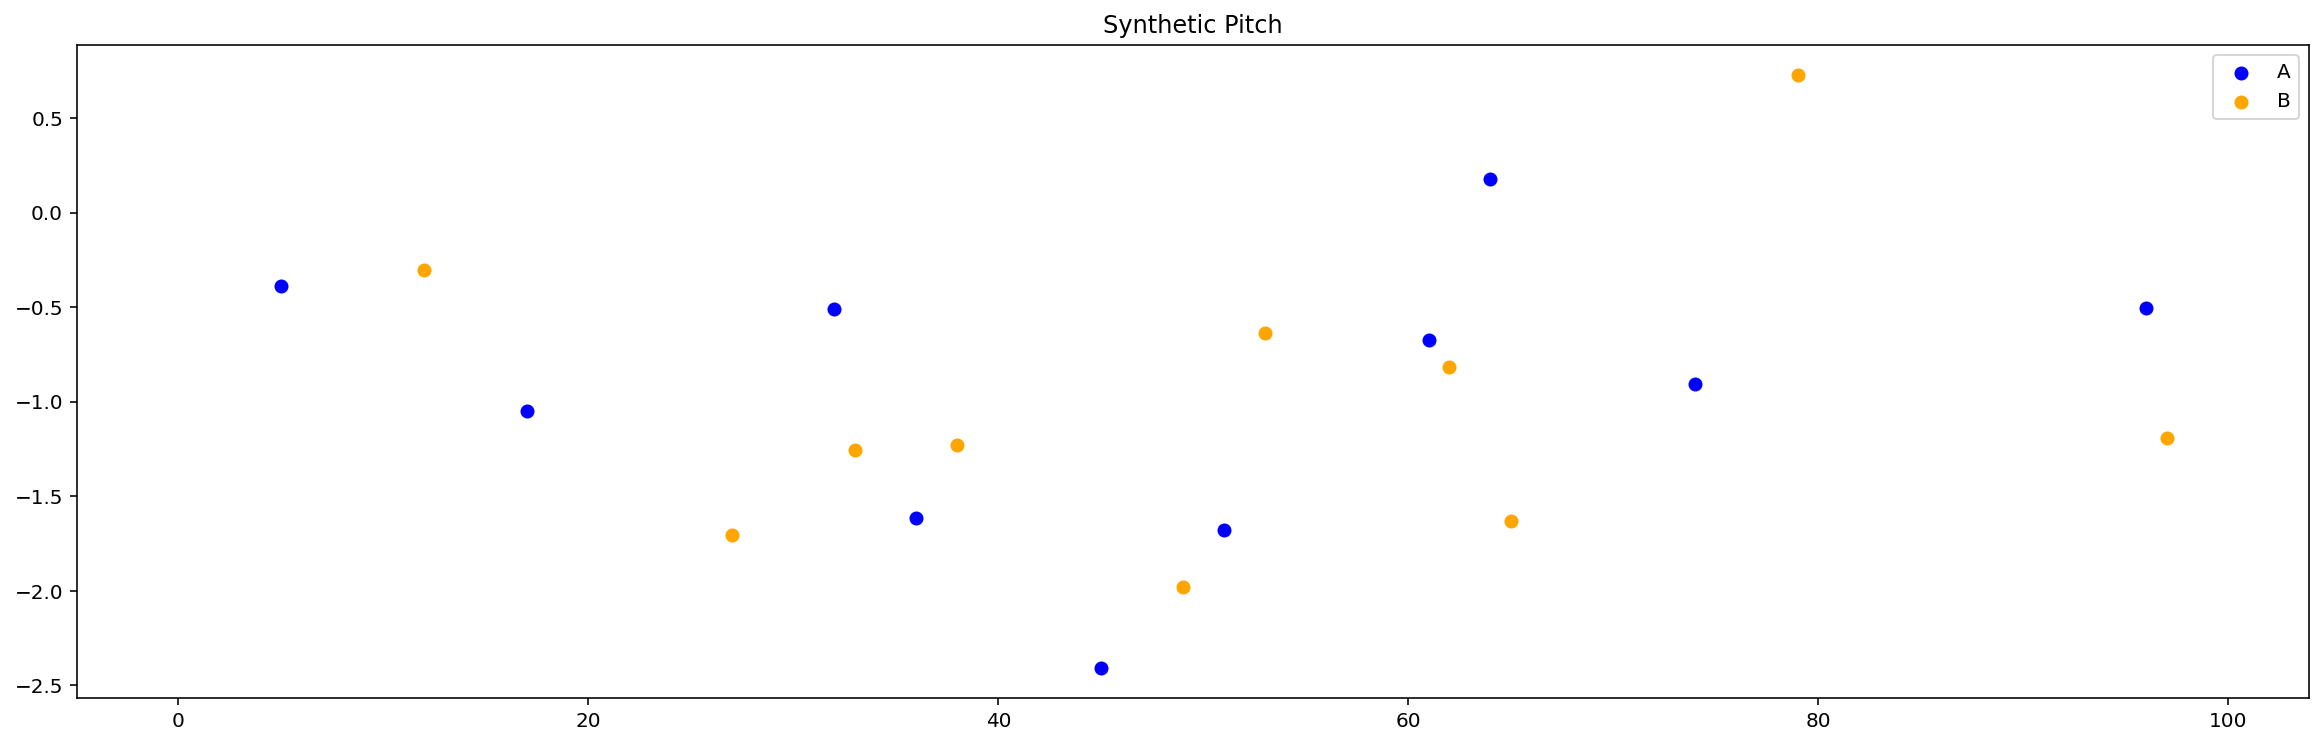

In [62]:
from src.synthetic.vocalics_generator import VocalicsGenerator
from scipy.stats import norm
from typing import Any, Dict, List

def plot_vocalic_series(series_a: List[float], series_b: List[float], marker: str = "o", 
                        ax: Any = None):
    if ax is None:
        plt.figure(figsize=(20, 6))
        ax = plt.gca()
    
    plt.scatter(range(len(series_a)), series_a, color="blue", label="A", marker=marker)
    plt.scatter(range(len(series_b)), series_b, color="orange", label="B", marker=marker)
    plt.legend()        
    
    return ax

prior_a = lambda feature_name : norm.rvs()
prior_b = lambda feature_name : norm.rvs()
pa = lambda feature_name, a, b, c : (prior_a(feature_name)**(1-c))*(norm.rvs(loc = b)**c)
pb = lambda feature_name, b, a, c : (prior_b(feature_name)**(1-c))*(norm.rvs(loc = a)**c)

random.seed(SEED)
np.random.seed(SEED)
vocalics_generator = VocalicsGenerator(discrete_cs, ["pitch", "intensity"], 0.2, prior_a, prior_b, pa, pb)
series_a, series_b = vocalics_generator.generate_evidence()
ax_pitch = plot_vocalic_series(series_a["pitch"], series_b["pitch"])
ax_pitch.set_title("Synthetic Pitch")
ax_pitch = plot_vocalic_series(series_a["intensity"], series_b["intensity"])
ax_pitch.set_title("Synthetic Pitch")

In [231]:
var_a = 2
var_b = 5

In [330]:
def generate_features(c_series: List[int] , var_a: float, var_b: float):
    a_series = []
    b_series = []
    for t, c in enumerate(c_series): 
        if t == 0 or c == 0:
            a = np.random.normal(0, 1, 1)[0]
            b = np.random.normal(0, 1, 1)[0]        
        else:
            a = np.random.normal(b_series[t-1], np.sqrt(var_a), 1)[0]
            b = np.random.normal(a_series[t-1], np.sqrt(var_b), 1)[0]
        
        a_series.append(a)
        b_series.append(b)
            
    return np.array(a_series), np.array(b_series)

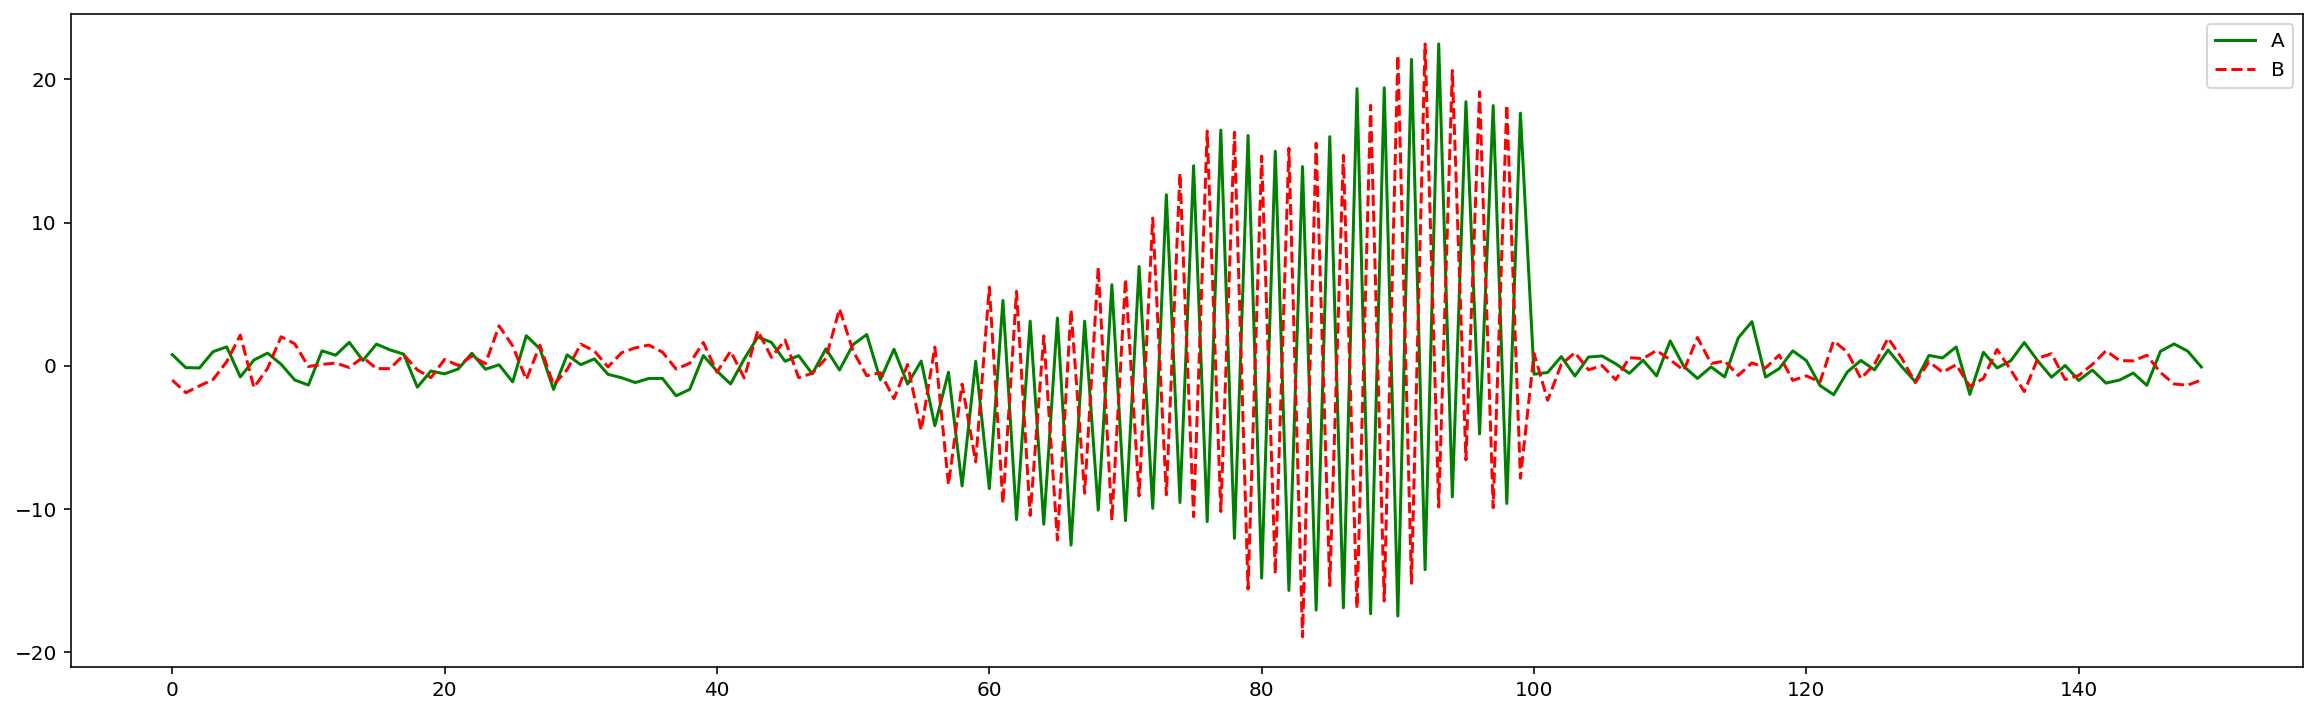

In [331]:
c_series = [0] * 50 + [1] * 50 + [0] * 50
a_series, b_series = generate_features(c_series, var_a, var_b)

plt.figure(figsize=(20, 6))
plt.plot(range(len(a_series)), a_series, color="green", label="A")
plt.plot(range(len(b_series)), b_series, color="red", label="B", linestyle="--")
plt.legend()

To estimate the parameters of the conditional distribution of features as well as coordination, we will use gibbs sampling. Derivations for the posteriors were obtained algebraically and are omitted in this notebook. The closed-form posteriors are.

1. $\sigma^2_A$

$
\begin{align}
A &= \alpha_A + 0.5*\sum_{i=1}^T C_t\\
B &= \beta_A + 0.5*\sum_{i=1}^T C_t(A_t - B_{t-1})^2\\
\sigma^2_A &\sim \Gamma^{-1}(A, B)
\end{align}
$

2. $\sigma^2_B$

$
\begin{align}
C &= \alpha_B + 0.5*\sum_{i=1}^T C_t\\
D &= \beta_B + 0.5*\sum_{i=1}^T C_t(B_t - A_{t-1})^2\\
\sigma^2_B &\sim \Gamma^{-1}(C, D)
\end{align}
$

3. $C_t$

$
\begin{align}
C_t &\sim \propto \left[(1-p_c)\exp\left(-\frac{(A_t^2 + B_t^2)}{2}\right), \frac{p_C}{\sigma_A\sigma_B}\exp\left(-\frac{(A_t - B_{t-1})^2}{\sigma_A^2} - \frac{(B_t - A_{t-1})^2}{2\sigma_B^2}\right)\right]
\end{align}
$

In [345]:
def gibbs(num_samples: int, a_series: np.ndarray, b_series: np.ndarray, p_c: float = 0.5,
          alpha_a: float = 1, beta_a: float = 1, alpha_b: float = 1, beta_b: float = 1):
    
    T = a_series.size
    
    # Initialize variables randomly
    c_series = np.random.binomial(n=1, p=p_c, size=T)
    var_a = invgamma(a = alpha_a, scale = beta_a).rvs()
    var_b = invgamma(a = alpha_b, scale = beta_b).rvs()
        
    c_samples = []
    var_a_samples = []
    var_b_samples = []
    
    # MCMC
    for i in range(num_samples):
        # var_A
        A = alpha_a + 0.5 * (np.sum(c_series[1:]))
        B = beta_a + 0.5 * (np.sum(c_series[1:] * np.square(a_series[1:] - b_series[:-1])))
        var_a = invgamma(a = A, scale = B).rvs()
        
        # var_B
        C = alpha_b + 0.5 * (np.sum(c_series[1:]))
        D = beta_b + 0.5 * (np.sum(c_series[1:] * np.square(b_series[1:] - a_series[:-1])))
        var_b = invgamma(a = C, scale = D).rvs()
        
        # c
        E = (1 - p_c)*np.exp(-(np.square(a_series[1:]) + np.square(b_series[1:]))/2)
        F = (p_c/(np.sqrt(var_a*var_b)))*np.exp(-0.5*(np.square(a_series[1:] - b_series[:-1])/var_a + np.square(b_series[1:] - a_series[:-1])/var_b))
        dist = np.zeros((2, T))
        dist[0,0] = 1 - p_c
        dist[1,0] = p_c
        dist[0,1:] = E + 10E-16
        dist[1,1:] = F + 10E-16
        dist /= np.sum(dist, axis=0)  
        c_series = np.random.binomial(n=1, p=dist[1,:])
#         c_series = dist[1,:]
        
        # Save samples
        c_samples.append(c_series)
        var_a_samples.append(var_a)
        var_b_samples.append(var_b)
    
    return np.array(c_samples), np.array(var_a_samples), np.array(var_b_samples)

In [346]:
(c_samples, vars_a, vars_b) = gibbs(10000, a_series, b_series)

print(f"Var A = {np.mean(vars_a[-800:])}")
print(f"Var B = {np.mean(vars_b[-800:])}")

Var A = 1.6834004445599098
Var B = 3.8954251751569733


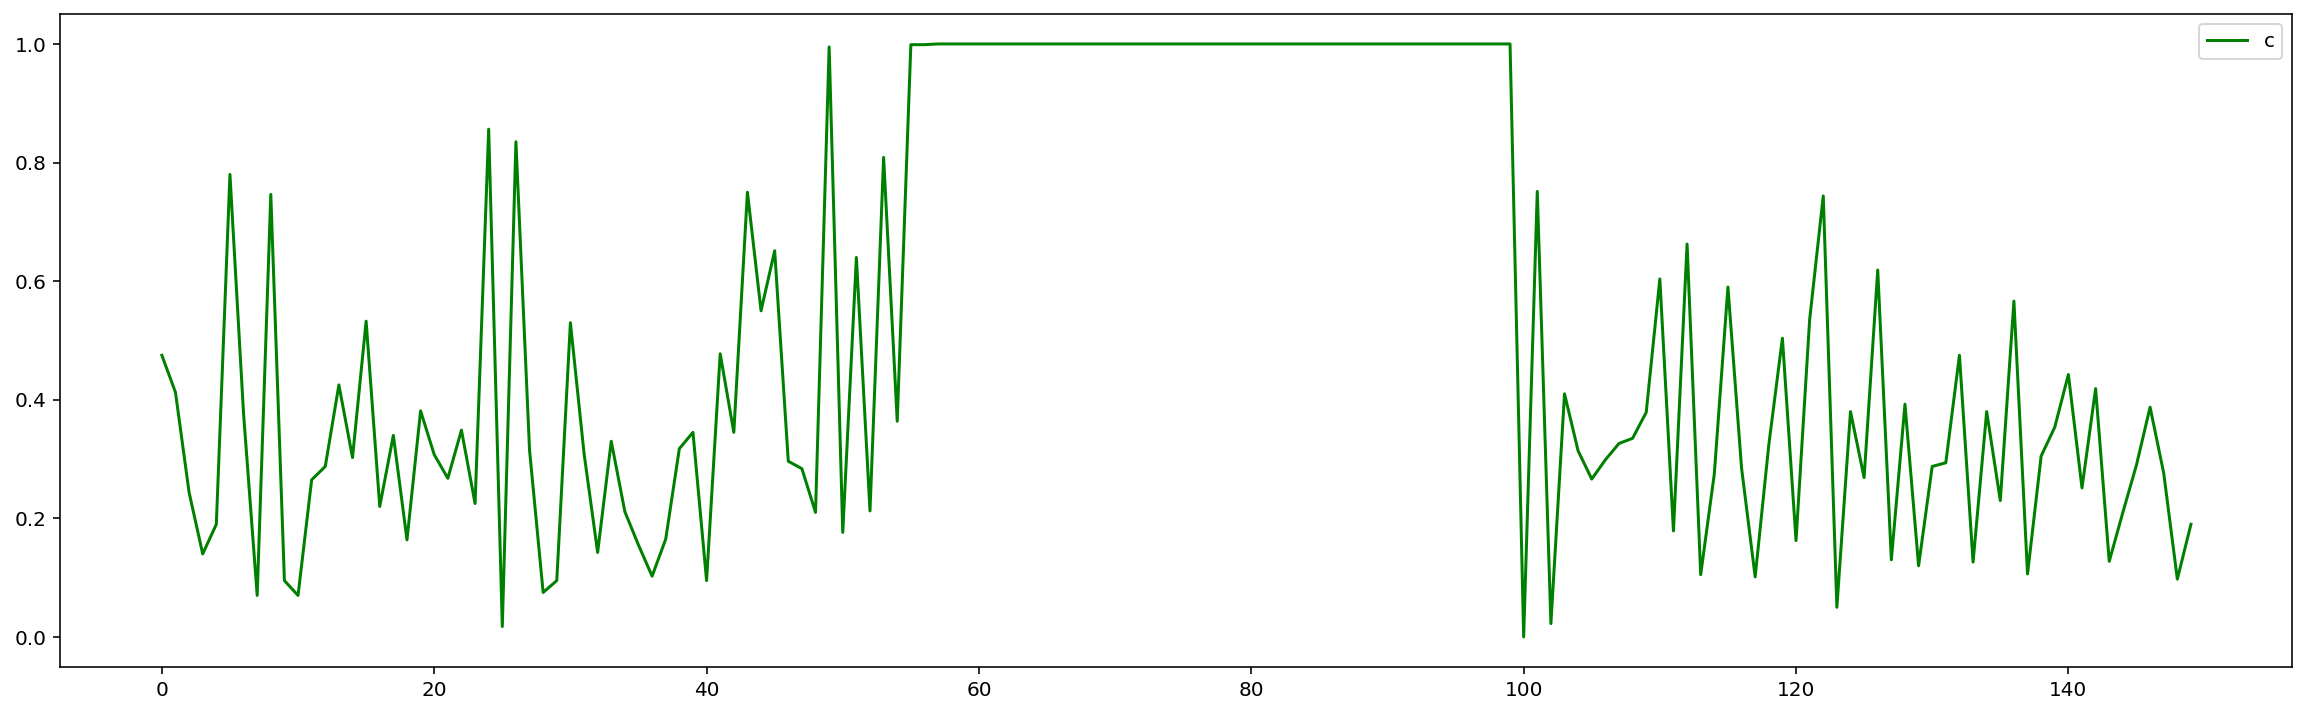

In [347]:
plt.figure(figsize=(20, 6))
plt.plot(range(c_samples.shape[1]), np.mean(c_samples[-800:,:], axis=0), color="green", label="c")
plt.legend()

### Continuous Coordination (soft coupling)

The second approach is to model coordination as a continuous variable that balances the extend to which $B_t$ depends on $A_{t-1}$ and its prior. 

In [ ]:
std = 
xs = np.linspace(0, 1, 100)
z = np.sqrt(np.pi / 2)